# Examples: Modular Superpixel Tokenization in Vision Transformers

![SPiT Figure 2](../assets/fig2.png "Examples of unsupervised segmentation from SPiT-B16")

**This notebook demonstrates how to:**

- load a pretrained superpixel transformer model
- evaluate the model on ImageNet1k validation
- extract segmentation maps for each image in the model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as T
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import sys

plt.rcParams['figure.figsize'] = (7,7)

# Make random colormap for visualizing segmentations
cmap = mpl.colors.ListedColormap(torch.rand(256**2,3).numpy())

# Add parent folder to sys.path
sys.path.append('../')

In [3]:
imgsize = 384
root = ... # Add your local folder here
tf = tv.transforms.Compose([
    T.RandomResizedCrop((imgsize, imgsize), (1,1)),
    T.ToTensor(),
])
data = tv.datasets.ImageNet(root, split='val', transform=tf)

In [4]:
# Set default device
device = torch.device('cuda:0')
batch_size = 512

# Create dataloader
dataloader = torch.utils.data.DataLoader(
    data, batch_size, num_workers=4, prefetch_factor=2, pin_memory=True
)

In [5]:
from spit import load_model

# Load model using package
_models = dict(
    SPiT_S16=load_model.load_SPiT_S16,
    SPiT_B16=load_model.load_SPiT_B16,
    ViT_S16=load_model.load_ViT_S16,
    ViT_B16=load_model.load_ViT_B16,
    RViT_S16=load_model.load_RViT_S16,
    RViT_B16=load_model.load_RViT_B16,
)

_arch = 'SPiT_B16'
_grad = True
_suffix = '_grad' if _grad else ''
_pretrained = True
model = _models.get(_arch)(grad=_grad, pretrained=_pretrained)
model.to(device)
model.eval();

In [6]:
# Optionally, use dataparallel for eval in notebook

cur_model = model
use_ddp = True
if use_ddp:
    cur_model = nn.DataParallel(model, [0,1,2,3])

## Evaluation

To test that the model is working correctly, we run a simple evaluation loop.

**Note:** this requires you to have initialized a working ImageNet1k dataset in previous cells.

In [7]:
# Evaluate model

import numpy as np
accs = []
report_freq = 1

print('----|  Start Evaluation  |----')
for i, (img, lab) in enumerate(dataloader):
    with torch.no_grad():
        out = cur_model(img.to(device))
        acc = (out.argmax(-1) == lab.to(device)).float().mean().item()
        accs.append(acc)
        if i % report_freq == 0:
            print(f'{i:4d}', '/', len(dataloader), f'{acc:7.5f}', f'{np.mean(accs):7.5f}')

print('----| Evaluation finished |----')
print(f'{i+1:4d}', '/', len(dataloader), f'{acc:7.5f}', f'{np.mean(accs):7.5f}')

----|  Start Evaluation  |----
   0 / 98 0.79297 0.79297
   1 / 98 0.81055 0.80176
   2 / 98 0.82031 0.80794
   3 / 98 0.80859 0.80811
   4 / 98 0.81836 0.81016
   5 / 98 0.79297 0.80729
   6 / 98 0.78711 0.80441
   7 / 98 0.80273 0.80420
   8 / 98 0.79883 0.80360
   9 / 98 0.81641 0.80488
  10 / 98 0.83789 0.80788
  11 / 98 0.79492 0.80680
  12 / 98 0.80469 0.80664
  13 / 98 0.80078 0.80622
  14 / 98 0.80078 0.80586
  15 / 98 0.78906 0.80481
  16 / 98 0.78711 0.80377
  17 / 98 0.82422 0.80490
  18 / 98 0.79297 0.80428
  19 / 98 0.81445 0.80479
  20 / 98 0.79492 0.80432
  21 / 98 0.80273 0.80424
  22 / 98 0.78320 0.80333
  23 / 98 0.81445 0.80379
  24 / 98 0.79883 0.80359
  25 / 98 0.77148 0.80236
  26 / 98 0.78320 0.80165
  27 / 98 0.80078 0.80162
  28 / 98 0.78906 0.80119
  29 / 98 0.79688 0.80104
  30 / 98 0.78906 0.80066
  31 / 98 0.78516 0.80017
  32 / 98 0.79688 0.80007
  33 / 98 0.81641 0.80055
  34 / 98 0.79492 0.80039
  35 / 98 0.78711 0.80002
  36 / 98 0.79492 0.79988
  37 / 

## Extracting Segmentations from the Model

Segmentations can be extracted by passing `return_seg=True` to the model.

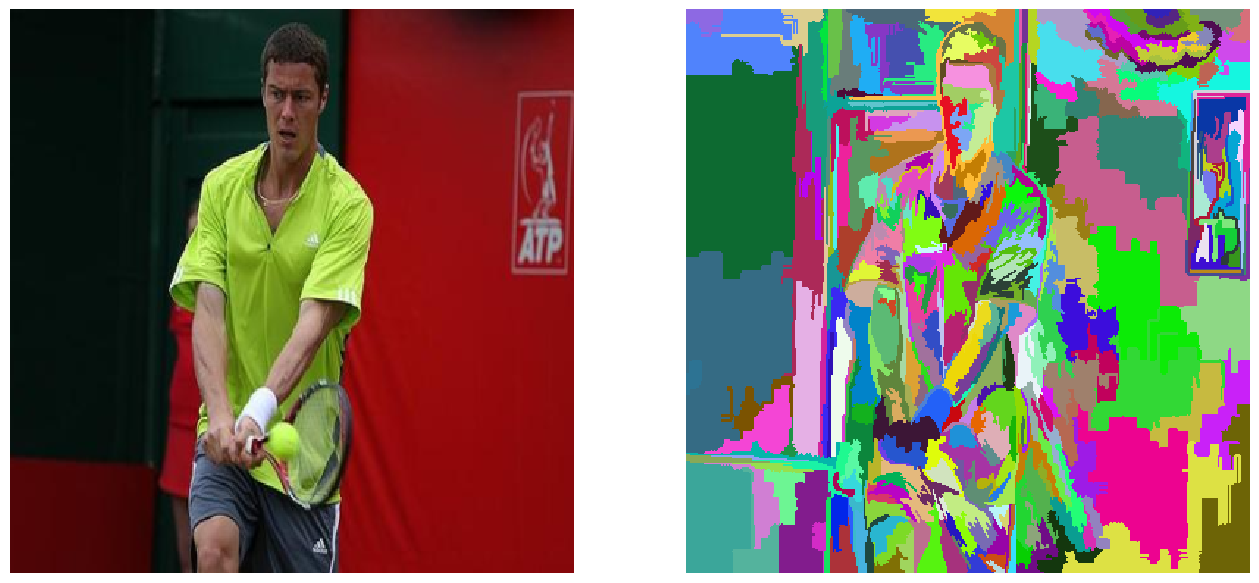

In [8]:
# Test superpixel segmentation
torch.cuda.empty_cache()

with torch.no_grad():
    out, seg = cur_model(img, return_seg=True)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].matshow(img.cpu().permute(0,2,3,1)[16])
ax[1].matshow(seg.cpu()[16], cmap=cmap)
for a in ax.flatten(): a.axis('off')